In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysta
import stc

import os

%load_ext autoreload
%autoreload 2

## run for all cells (OFF LINE)

run
```
python3 stcl_batch.py [DATASET] --dim D
```

datasets
* 20180618
* 20180621
* 20180626
* 20180828

## load stim and spike data

In [2]:
folder_name = "data"

# dataset_name = "20180618"
# dataset_name = "20180621"
dataset_name = "20180626"
# dataset_name = "20180828"

stim, spike_train, info = pysta.load_data(dataset_name, folder_name)

# channel_names = [ch.replace("ch_","") for ch in info["channel_names"]]   # NOT NEEDED ANYMORE
# info["channel_names"]
# info["cell_types"]


['dataset_name', 'stim', 'spike_train', 'info']
(64, 9000)
(156, 9000)
{'channel_names': ['12a', '12b', '12c', '13a', '13b', '13c', '13d', '13e', '14a', '14b', '14c', '14d', '16a', '16b', '16c', '17a', '17b', '17c', '17d', '21a', '21b', '21c', '21d', '21e', '22a', '22b', '23a', '23b', '23c', '23d', '25a', '25b', '25c', '26a', '26b', '26c', '26d', '27a', '27b', '27c', '27d', '28a', '28b', '28c', '31a', '31b', '31c', '31d', '32a', '32b', '32c', '33a', '33b', '33c', '33d', '35a', '35b', '35c', '35d', '35e', '35f', '35g', '36a', '36b', '36c', '36d', '37a', '37b', '37c', '37d', '37e', '38a', '41a', '41b', '41c', '41d', '42a', '42b', '42c', '43a', '43b', '43c', '45a', '45b', '45c', '46a', '46b', '47a', '48a', '48b', '48c', '48d', '48e', '51a', '51b', '53a', '53b', '53c', '53d', '54a', '54b', '54c', '54d', '56a', '56b', '58a', '61a', '61b', '62a', '62b', '63a', '63b', '63c', '63d', '63e', '64a', '65a', '65b', '65c', '68a', '68b', '71a', '71b', '71c', '72a', '72b', '72c', '72d', '72e', '73a', 

In [3]:
# calc number of spikes
tap = 8 # -700 ms ~ 0

num_samples = list()
num_spikes = list()
for idx in range(spike_train.shape[0]):    
    spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[idx], tap)
    
    num_samples.append(spike_triggered_stim.shape[0])
    num_spikes.append(np.sum(spike_count))

num_samples_df = pd.DataFrame({"channel_name": info["channel_names"], "number_of_samples": num_samples, "number_of_spikes": num_spikes})
# num_samples_df

## read largest eigenvalues from STC results

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b94c210>,
      dtype=object)

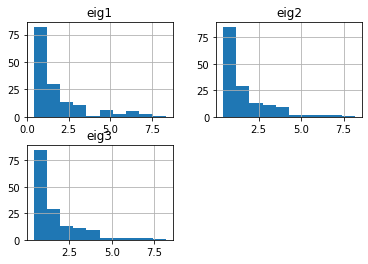

In [4]:
folder_name = "{}_tap{}_stc_classic".format(dataset_name, tap)

largest_eigen_values = list()
second_largest_eigen_values = list()
third_largest_eigen_values = list()
for channel_name in info["channel_names"]:
    filename = "ch_{}_eig_val.txt".format(channel_name)
    #print(os.path.join(folder_name,filename))    
    eigs = np.loadtxt(os.path.join(folder_name,filename))
    largest_eigen_values.append(eigs[0])
    second_largest_eigen_values.append(eigs[1])
    third_largest_eigen_values.append(eigs[1])    
largest_eigen_values_df = pd.DataFrame({"channel_name": info["channel_names"], "eig1": largest_eigen_values, "eig2": second_largest_eigen_values, "eig3": third_largest_eigen_values})

largest_eigen_values_df.hist()

## read clustering results

In [5]:
dim = 3
folder_name = "{}_tap{}_stc_classic_cluster_dim{}".format(dataset_name, tap, dim)
filename = os.path.join(folder_name, "clusters.csv")

clusters = pd.read_csv(filename)
# weights
# weights.head()

clusters["max_weight"] = np.maximum(clusters["weight1"], clusters["weight2"])

# combine number of samples
clusters = clusters.merge(num_samples_df, on="channel_name") #, how="outer")

# combine largest eigen values
clusters = clusters.merge(largest_eigen_values_df, on="channel_name", how="outer")


filename = os.path.join(folder_name, "clusters_combined.csv")
clusters.to_csv(filename, index=None)

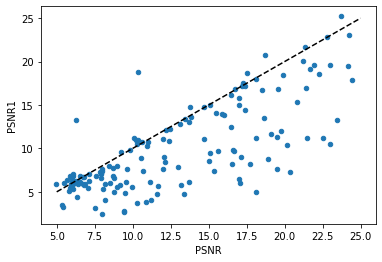

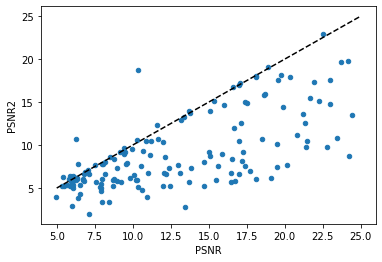

In [6]:
clusters.plot.scatter("PSNR", "PSNR1")
plt.plot([5,25], [5,25], 'k--')
clusters.plot.scatter("PSNR", "PSNR2")
plt.plot([5,25], [5,25], 'k--')

In [7]:
idx_PSNR1_increased = np.where(clusters["PSNR"] < clusters["PSNR1"])
idx_PSNR2_increased = np.where(clusters["PSNR"] < clusters["PSNR2"])

clusters.iloc[np.union1d(idx_PSNR1_increased, idx_PSNR2_increased)]

,channel_name,PSNR,converged,PSNR1,PSNR2,weight1,weight2,inner_product,max_weight,number_of_samples,number_of_spikes,eig1,eig2,eig3
4,13b,17.037106,True,6.038273,17.231304,0.039346,0.960654,0.554303,0.960654,648,998,1.284069,1.216870,1.216870
5,13c,17.011753,True,6.535955,17.024650,0.034309,0.965691,0.846492,0.965691,458,628,1.484082,1.419447,1.419447
7,13e,5.878484,True,5.404218,6.448895,0.749543,0.250457,-0.533740,0.749543,112,112,2.438375,2.330179,2.330179
9,14b,13.728054,True,6.136497,14.004267,0.042539,0.957461,0.444227,0.957461,655,760,1.045665,1.023996,1.023996
10,14c,10.645620,True,10.703179,4.741463,0.969209,0.030791,0.127063,0.969209,208,214,1.768600,1.759664,1.759664
11,14d,5.396635,True,3.222904,6.318851,0.044118,0.955882,0.051923,0.955882,68,73,7.419156,4.245199,4.245199
17,17c,6.080982,True,6.771808,5.401028,0.685045,0.314955,0.031393,0.685045,210,394,1.924233,1.897407,1.897407
18,17d,6.537107,True,6.814184,5.359176,0.864000,0.136000,0.020976,0.864000,76,88,4.692953,3.993569,3.993569
23,21e,11.634252,True,4.771751,12.319544,0.052118,0.947882,0.216931,0.947882,132,138,2.547135,2.431784,2.431784
24,22a,17.556724,True,18.744086,14.883253,0.644070,0.355930,-0.479001,0.644070,1803,2860,0.838246,0.704459,0.704459


In [8]:
clusters.iloc[np.intersect1d(idx_PSNR1_increased, idx_PSNR2_increased)]

,channel_name,PSNR,converged,PSNR1,PSNR2,weight1,weight2,inner_product,max_weight,number_of_samples,number_of_spikes,eig1,eig2,eig3
25,22b,6.267735,True,13.270177,10.658682,0.313833,0.686167,-0.287884,0.686167,1649,2413,0.835159,0.782430,0.782430
64,36c,10.318830,True,18.844527,18.800608,0.524268,0.475732,-0.553698,0.524268,2337,4098,0.798256,0.620102,0.620102
90,48c,5.989198,True,6.864108,6.080623,0.516777,0.483223,-0.656878,0.516777,231,231,1.561925,1.505998,1.505998


In [9]:
clusters_with_negative_inner_product = clusters.loc[clusters["inner_product"]<0,:]

print(len(clusters_with_negative_inner_product), len(clusters))
clusters_with_negative_inner_product

64 156


,channel_name,PSNR,converged,PSNR1,PSNR2,weight1,weight2,inner_product,max_weight,number_of_samples,number_of_spikes,eig1,eig2,eig3
2,12c,9.580539,True,6.146813,7.826516,0.264044,0.735956,-0.581505,0.735956,80,80,2.975778,2.937412,2.937412
3,13a,16.538420,True,8.264379,8.405457,0.496224,0.503776,-0.208694,0.503776,6610,8830,0.432604,0.424380,0.424380
6,13d,7.128652,True,6.192117,6.585491,0.077614,0.922386,-0.081680,0.922386,288,342,1.776912,1.658930,1.658930
7,13e,5.878484,True,5.404218,6.448895,0.749543,0.250457,-0.533740,0.749543,112,112,2.438375,2.330179,2.330179
13,16b,6.715108,True,5.933610,5.970263,0.720404,0.279596,-0.068018,0.720404,184,234,2.185584,2.136243,2.136243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,82a,15.087140,True,9.473015,14.013852,0.419707,0.580293,-0.008274,0.580293,3219,5543,0.585823,0.543183,0.543183
142,82b,15.507029,True,14.126434,5.992347,0.582306,0.417694,-0.139983,0.582306,1617,2842,0.798825,0.714066,0.714066
144,83a,20.351671,True,7.239815,17.908897,0.506330,0.493670,-0.064913,0.506330,6618,17646,0.493440,0.462766,0.462766
152,86d,8.678597,True,6.818092,5.929542,0.569566,0.430434,-0.258929,0.569566,149,151,2.244849,2.097623,2.097623


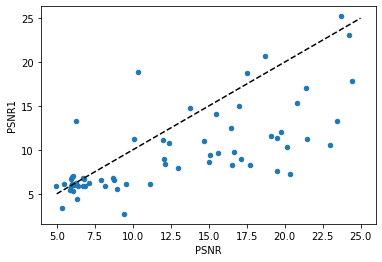

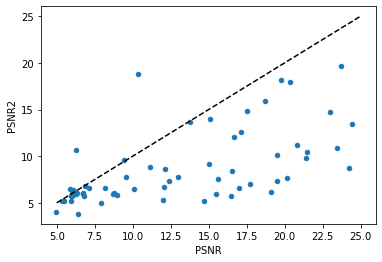

In [10]:
#plt.plot(clusters_with_negative_inner_product[])
clusters_with_negative_inner_product.plot.scatter("PSNR", "PSNR1")
plt.plot([5,25], [5,25], 'k--')
clusters_with_negative_inner_product.plot.scatter("PSNR", "PSNR2")
plt.plot([5,25], [5,25], 'k--')

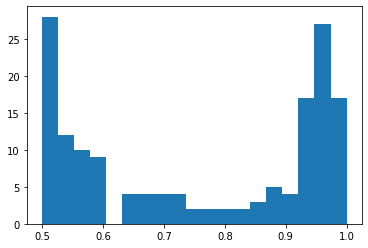

In [11]:
bins = np.linspace(0.5, 1, 20)
plt.hist(clusters["max_weight"], bins=bins)
#clusters["max_weight"].hist()
#plt.
plt.savefig("{}/max_weight_hist.png".format(folder_name))

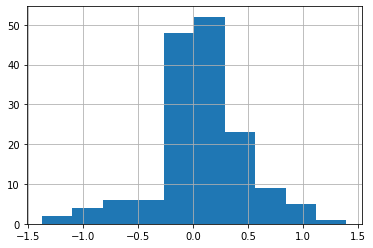

In [12]:
clusters["inner_product"].hist()
plt.savefig("{}/inner_product_hist.png".format(folder_name))

## Combine with cell type info

In [13]:
cell_type = pd.DataFrame({"channel_name": info["channel_names"],
                          "cell_type":   info["cell_types"]})
cell_type

clusters = clusters.merge(cell_type, on="channel_name", how="outer")

In [14]:
filename = os.path.join(folder_name, "clusters_combined.csv")
clusters.to_csv(filename, index=None)

## repeat for each cell type

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d75ee90>,
      dtype=object)

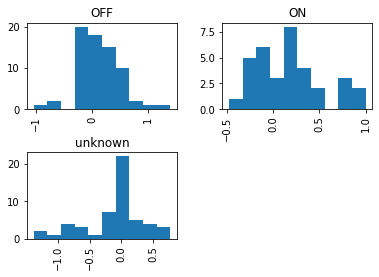

In [15]:
# clusters
#info["cell_types"]
#clusters.groupby("cell_type").hist()
clusters["inner_product"].hist(by=clusters["cell_type"])

In [16]:
# helper function to plot histograms of a column by cell_type
def plot_histogram_by_cell_type(clusters, col_name):
    idx_on = clusters["cell_type"] == "ON"
    clusters.loc[idx_on, col_name].hist(alpha=0.6)

    idx_on = clusters["cell_type"] == "OFF"
    clusters.loc[idx_on, col_name].hist(alpha=0.6)

    idx_unknown = clusters["cell_type"] == "unknown"
    clusters.loc[idx_unknown, col_name].hist(alpha=0.6)

    plt.xlabel(col_name)
    plt.ylabel("count")
    plt.legend(["ON", "OFF", "unknown"])

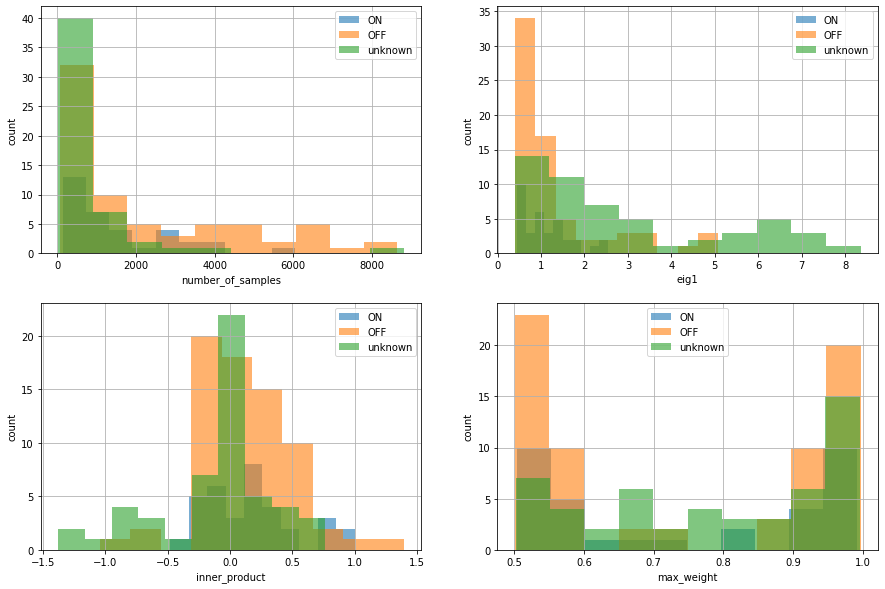

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plot_histogram_by_cell_type(clusters, "number_of_samples")
plt.subplot(222)
plot_histogram_by_cell_type(clusters, "eig1")
plt.subplot(223)
plot_histogram_by_cell_type(clusters, "inner_product")
plt.subplot(224)
plot_histogram_by_cell_type(clusters, "max_weight")

plt.savefig("{}_tap{}_cluster_dim{}.pdf".format(dataset_name, tap, dim))
plt.savefig("{}_tap{}_cluster_dim{}.png".format(dataset_name, tap, dim))

## Focus on data with enough samples

51
OFF        29
ON         15
unknown     7
Name: cell_type, dtype: int64


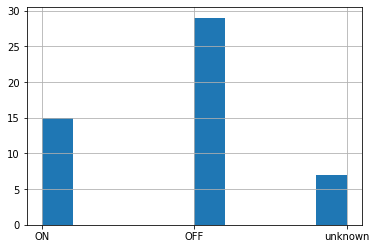

In [18]:
idx_enough_samples = clusters["number_of_spikes"]>512*4
# idx_enough_samples = clusters["number_of_samples"]>512*4
#idx_enough_samples = clusters["number_of_samples"]>512 # eigen values are too large
clusters_with_enough_samples = clusters.loc[idx_enough_samples]

print(len(clusters_with_enough_samples))

print(clusters_with_enough_samples["cell_type"].value_counts())

clusters_with_enough_samples["cell_type"].hist()

In [19]:
idx_unknown = clusters_with_enough_samples["cell_type"]=="unknown"

clusters_with_enough_samples.loc[idx_unknown].to_csv("{}_tap{}_cluster_with_enough_samples_dim{}_unknown.csv".format(dataset_name, tap, dim))

clusters_with_enough_samples.loc[idx_unknown]

,channel_name,PSNR,converged,PSNR1,PSNR2,weight1,weight2,inner_product,max_weight,number_of_samples,number_of_spikes,eig1,eig2,eig3,cell_type
25,22b,6.267735,True,13.270177,10.658682,0.313833,0.686167,-0.287884,0.686167,1649,2413,0.835159,0.782430,0.782430,unknown
64,36c,10.318830,True,18.844527,18.800608,0.524268,0.475732,-0.553698,0.524268,2337,4098,0.798256,0.620102,0.620102,unknown
76,42a,5.962683,True,5.889491,5.789268,0.502303,0.497697,-0.238059,0.502303,8822,15907,0.396756,0.395866,0.395866,unknown
104,56b,6.055893,True,7.020343,5.797832,0.492036,0.507964,-0.286165,0.507964,2731,2961,0.521560,0.518974,0.518974,unknown
107,61b,9.815396,True,9.876353,6.194898,0.987119,0.012881,0.011300,0.987119,1812,2148,0.679410,0.648867,0.648867,unknown
108,62a,8.960171,True,5.505457,5.801876,0.507850,0.492150,-0.260077,0.507850,3910,4582,0.491259,0.482335,0.482335,unknown
137,76a,10.540886,True,8.906883,7.611043,0.429369,0.570631,0.020360,0.570631,1475,2444,0.691615,0.672735,0.672735,unknown


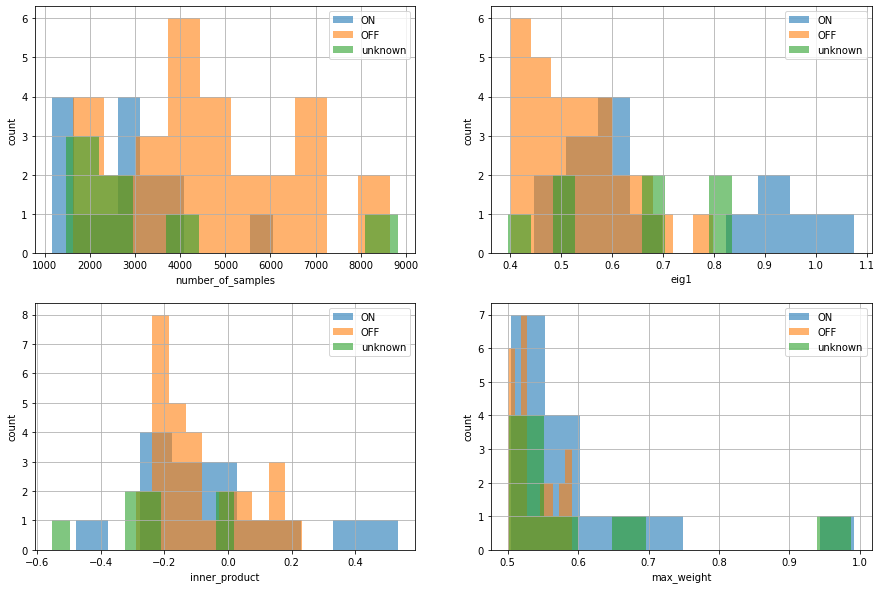

In [20]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plot_histogram_by_cell_type(clusters_with_enough_samples, "number_of_samples")
plt.subplot(222)
plot_histogram_by_cell_type(clusters_with_enough_samples, "eig1")
plt.subplot(223)
plot_histogram_by_cell_type(clusters_with_enough_samples, "inner_product")
plt.subplot(224)
plot_histogram_by_cell_type(clusters_with_enough_samples, "max_weight")

plt.savefig("{}_tap{}_cluster_with_enough_samples_dim{}.pdf".format(dataset_name, tap, dim))
plt.savefig("{}_tap{}_cluster_with_enough_samples_dim{}.png".format(dataset_name, tap, dim))

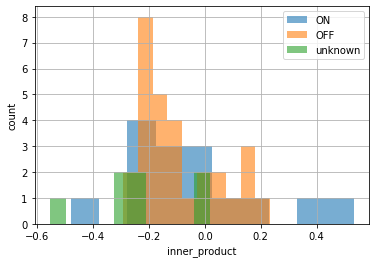

In [21]:
# plot inner product only
plot_histogram_by_cell_type(clusters_with_enough_samples, "inner_product")
plt.savefig("figure/inner_product_hist.png")
plt.savefig("figure/inner_product_hist.pdf")

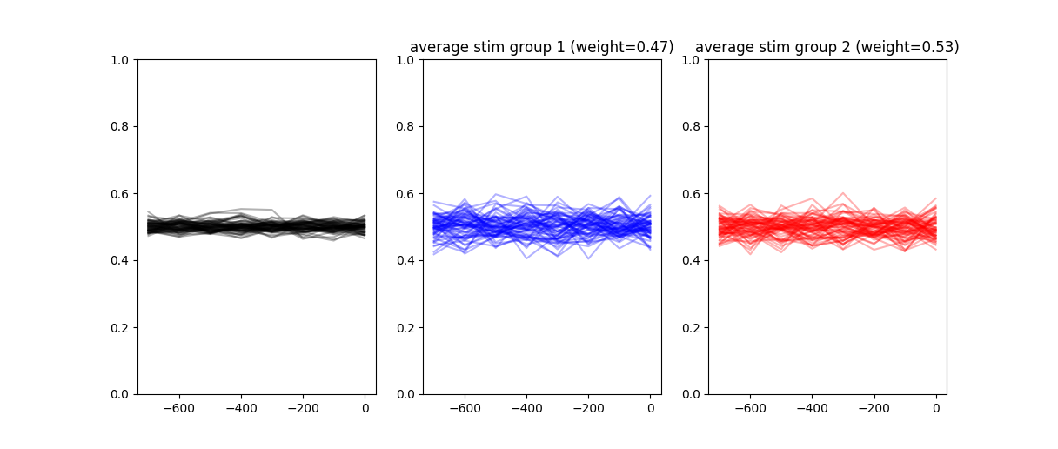

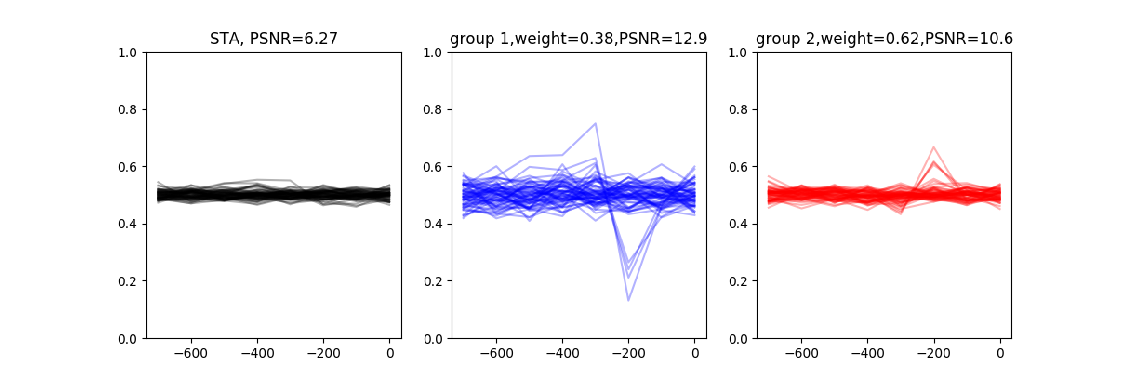

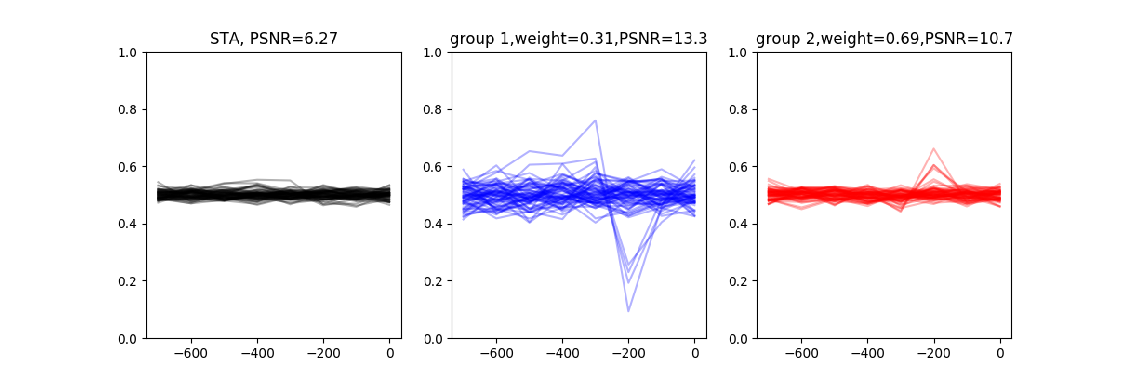

In [27]:
## compare clustering results for different dimensions
#36c_d3_centers
folder_name1 = folder_name[:-1] +"1"
folder_name2 = folder_name[:-1] +"2"
folder_name3 = folder_name[:-1] +"3"

channel_name = "22b"
# channel_name = "36c"

# channel_name = "42a"
# channel_name = "56b"
# channel_name = "62a"


plt.figure(figsize=(20,8))
im1 = plt.imread(os.path.join(folder_name1, "{}_d1_centers.png".format(channel_name)))
plt.imshow(im1)
plt.box('off')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,8))
im1 = plt.imread(os.path.join(folder_name2, "{}_d2_centers.png".format(channel_name)))
plt.imshow(im1)
plt.box('off')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,8))
im1 = plt.imread(os.path.join(folder_name3, "{}_d3_centers.png".format(channel_name)))
plt.imshow(im1)
plt.box('off')
plt.axis('off')
plt.show()

## paired t-test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

In [23]:
# from scipy import stats

In [24]:
# stats.ttest_rel(clusters_dim2["max_weight"], clusters_dim2["max_weight"])

In [25]:
# stats.ttest_rel(clusters_dim2["inner_product"], clusters_dim2["inner_product"])